# Microtask 2  (Implementing CHAOSS metrics with Perceval idea)

By: José Alberto Marcial Sánchez

## Table of contents
<ol>
    <li><a href=#objective>Objective</a></li>
    <li><a href=#retrieving>Retrieving the data</a></li>
    <li><a href=#defining>Defining functions to retrieve important info from issues, pull requests and commits</a></li>
    <li><a href=#code_changes>The Code_Changes Class</a></li>
    <li><a href=#split_by_quarters>The splitByQuarters function</a></li>
    <li><a href=#usage_example>Usage example</a></li>
    <li><a href=#passing_csv>Passing the dataframe to CSV</a></li>
    <li><a href=#plotting>Useful Plots</a></li>
 <ol>

<h2><a id="objective" style="color:black;">Objective</a></h2>
<br>
Produce a notebook showing (and producing) a list with the activity per quarter: number of new committers, submitters of issues, and submitters of pull/merge requests, number of items (commits, issues, pull/merge requests), number of repositories with new items (all of this per quarter) as a table and as a CSV file. Pandas can be used for this

<h2><a id = "retrieving" style="color:black;"> Retrieving the data </a></h2>
<br>
For this exercise, we are going to retrieve information from the following repositories using perceval:
<ol>
    <li><a href = "https://github.com/google/blockly"> Google Blockly </a></li>
    <li><a href = "https://github.com/google/copybara"> Google Copybara</a></li>
    <li><a href = "https://github.com/google/dopamine">Google Dopamine</a></li>
</ol>

### Date of retrieval: April 6th 2019


The following commands were executed on the terminal to write the retrieved data to the info.json file. Remember that you need to replace the XXXX's with your Github API token

```` 
Google Blockly
retrieving commits
perceval git --json-line https://github.com/google/blockly > info.json

retrieving issues and pull requests
perceval github --json-line --category issue google blockly --sleep-for-rate -t XXXX >> info.json

Google Copybara
retrieving commits
perceval git --json-line https://github.com/google/copybara >> info.json

retrieving issues and pull requests
perceval github --json-line --category issue google copybara --sleep-for-rate -t XXXX >> info.json

Google Dopamine
retrieving commits
perceval git --json-line https://github.com/google/dopamine >> info.json

retrieving issues and pull requests
perceval github --json-line --category issue google dopamine --sleep-for-rate -t XXXX >> info.json


````

<h2><a id = "defining" style = "color:black;">Defining functions to retrieve important info from issues, pull requests and commits</a></h2>

In [385]:
import warnings
warnings.filterwarnings('ignore')

## Importing the necessary libraries for the analysis and data manipulation
import json
import datetime
from datetime import datetime, timedelta, date
import pandas as pd


##plotting libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [274]:
## Function based on the _summary function from the Code_changes class in the microstask 0 example

def summarizeIssuePullRequest(issue):
    '''
    This is a function for summarizing issue's relevant information 
    
    Parameters:
    issue(dict) : json's file line describing an issue
    
    Returns:
    dict: A non-nested dictionary which can be easily appended as a row of a dataframe
    '''
    cdata = issue['data']
    
    ##Adding just the relevant fields from the complete issue/pull
    summary = {
            'action': 'issue' if 'pull_request' not in cdata else 'pull_request',
            'repo': issue['origin'],
            'created_date': datetime.strptime(cdata['created_at'], "%Y-%m-%dT%H:%M:%SZ").date(),
            'author' : cdata['user']['login']
    }
    return summary

In [275]:
def summarizeCommit(commit):
    '''
    This is a function for summarizing commit's relevant information 
    
    Parameters:
    commit(dict) : json's file line describing a commit
    
    Returns:
    dict: A non-nested dictionary which can be easily appended as a row of a dataframe
    '''
    cdata = commit['data']
    
    ##Adding just the relevant fields from the commit
    summary = {
            'action': 'commit',
            'repo': commit['origin'],
            ##converting the date from a string to date format
            'created_date': datetime.strptime(cdata['CommitDate'],"%a %b %d %H:%M:%S %Y %z").date(),
            'author' : cdata['Author']
    }

    return summary

<h2><a id = "code_changes" style = "color:black">The Code_Changes Class</a></h2>

In [276]:
##This class was taken from the Code_changes-Git notebook in the wf-gmd CHAOSS repository
class Code_Changes:
    """"Class for Code_Changes for Git repositories.
    
    Objects are instantiated by specifying a file with the
    commits obtained by Perceval from a set of repositories.
    
    Contains individual list for Issues, Pull Requests and Commits
        
    :param path: Path to file with one Perceval JSON document per line
    """
    
    def __init__(self, path):
        
        self.changes = {'issue':[],'commit':[],'pull_request':[]}
        with open(path) as data_file:
            for data in data_file:
                line = json.loads(data)
                line_info = line['data']
                if(line['category'] ==  'commit'):
                    self.changes['commit'].append(summarizeCommit(line))
                else:
                    if ('pull_request' in line_info):
                        self.changes['pull_request'].append(summarizeIssuePullRequest(line))
                    else:
                        self.changes['issue'].append(summarizeIssuePullRequest(line))
        self.code_dataframe = {
            'commit':pd.DataFrame.from_dict(self.changes['commit']),
            'pull_request':pd.DataFrame.from_dict(self.changes['pull_request']),
            'issue':pd.DataFrame.from_dict(self.changes['issue'])
        }
        
        for frame in self.code_dataframe:
            self.code_dataframe[frame]['created_date'] = pd.to_datetime(self.code_dataframe[frame]['created_date'])
        
    def count(self, since = None, until = None):
        """Count number of items in a given range of dates
        
        :param since: Period start
        :param until: Period end
        """
        totals = {"commit":0,"issue":0,"pull_request":0}
        by_type = self.code_dataframe
        for key in by_type:
            df = by_type[key]
            df = df[(df['created_date'] >= since) & (df['created_date'] <= until)]
            totals[key] = len(df.index)
            
        return totals

<h2><a id = "split_by_quarters" style = "color:black">The splitByQuarters function</a></h2>

In [386]:
def splitByQuarters(first_year,last_year):
    '''
    The purpose of this function is creating a dictionary with all the existing quarters between the years passed as parameters
    
    Parameters:
    first_year(int) : year from which quarters are going to be created
    last_year(int) : year till which quarters are going to be created
    
    Returns:
    dict: A dictionary including the dates for all existing quarters between the first_year and last_year parameters
    '''
    ##assigning dates to each quarter of a year
    quarters = {'first':
                {
                    "bday":1,"bmonth":1,"eday":31,"emonth":3
                },
                "second":
                {
                    "bday":1,"bmonth":4,"eday":30,"emonth":6},
                "third":
                {
                    "bday":1,"bmonth":7,"eday":30,"emonth":9},
                "fourth":
                {
                    "bday":1,"bmonth":10,"eday":31,"emonth":12}
               }
    
    ##dictionary to be returned. quarter list will include the name of the quarter e.g first, second, third, fourth
    ##date_range is a list of tuples, each one specifying the starting date and the end date for a quarter
    results = {
        "quarter":[],
        "date_range":[]
    }
    
    ##We will create quarters for each year starting from the first_year and stopping in the last_year
    for year in range(first_year,last_year + 1):
        #for each year, we want to create 4 quarters, that's what this nested loop is doing
        for quarter in quarters:
            ##day and month in which the quarter begins
            dayb = (quarters[quarter]['bday'])
            monthb = (quarters[quarter]['bmonth'])
            
            ##day and month in which the quarter ends
            daye = (quarters[quarter]['eday'])
            monthe = (quarters[quarter]['emonth'])
            
            ##creating 2 date objects. They are composed of the day and month declared before, we are just adding the year
            dateB = date(year, monthb,dayb)
            dateF = date(year, monthe,daye)
            
            ##once we have the dates from which the current quarter is composed, we append them as a tuple and we also append the name of the quarter
            results['quarter'].append(quarter)
            results['date_range'].append((dateB,dateF)) 
            
    return results

<h2><a id = "usage_example" style = "color:black">Usage example</a></h2>

In [343]:
#Creating a Code_Changes object with data from the info.json file
data = Code_Changes('../Microtask_5/info.json')

In the `splitted_data` variable we will be storing the dates corresponding to each quarter in the range of dates passed to the function. In this case we want to analyze activity in quarters from 2015 till 2017

In [387]:
##exam`le of the dictionary created by the splitByQuarters function
splitted_data = splitByQuarters(2015,2017)
splitted_data

{'quarter': ['first',
  'second',
  'third',
  'fourth',
  'first',
  'second',
  'third',
  'fourth',
  'first',
  'second',
  'third',
  'fourth'],
 'date_range': [(datetime.date(2015, 1, 1), datetime.date(2015, 3, 31)),
  (datetime.date(2015, 4, 1), datetime.date(2015, 6, 30)),
  (datetime.date(2015, 7, 1), datetime.date(2015, 9, 30)),
  (datetime.date(2015, 10, 1), datetime.date(2015, 12, 31)),
  (datetime.date(2016, 1, 1), datetime.date(2016, 3, 31)),
  (datetime.date(2016, 4, 1), datetime.date(2016, 6, 30)),
  (datetime.date(2016, 7, 1), datetime.date(2016, 9, 30)),
  (datetime.date(2016, 10, 1), datetime.date(2016, 12, 31)),
  (datetime.date(2017, 1, 1), datetime.date(2017, 3, 31)),
  (datetime.date(2017, 4, 1), datetime.date(2017, 6, 30)),
  (datetime.date(2017, 7, 1), datetime.date(2017, 9, 30)),
  (datetime.date(2017, 10, 1), datetime.date(2017, 12, 31))]}

Once that we have our dates in a dictionary, we can start counting the number of items per category in our `data` object. Remeber, this object stores 1 dataframe per category, which are pull_request, issue and commit. So we will assign a variable for each of those categories, so we can be able to count how many of them exists per quarter

In [380]:
#creating variables referring to the different dataframes created by our 'data' Code_Changes object
pull_requests = data.code_dataframe['pull_request']
commits = data.code_dataframe['commit']
issues = data.code_dataframe['issue']

#adding fields to our original dictionary of quarters in which we will be storing the count for each category, the sum of them and the number of new contributors per category
splitted_data['#pull_requests'] = []
splitted_data['#commits'] = []
splitted_data['#issues'] = []
splitted_data['#new_pull_requesters'] = []
splitted_data['#new_issuers'] = []
splitted_data['#new_committers'] = []
splitted_data['#total_items'] = []


##In these dictionaries, we will keep the contributors to each category and we will be refreshing it's size info inside the for loop
unique_pull_requesters = {'authors':[], 'size':0}
unique_committers = {'authors':[], 'size':0}
unique_issuers  = {'authors':[], 'size':0}

##traversing the date_range tuples from the splitted_data variable, each tuple represent a quarter's begin and end dates
for dates in splitted_data['date_range']:
    curr_pull_requests = pull_requests[(pull_requests['created_date'] >= dates[0]) & (pull_requests['created_date'] <= dates[1])]
    curr_commits = commits[(commits['created_date'] >= dates[0]) & (commits['created_date'] <= dates[1])]
    curr_issues = issues[(issues['created_date'] >= dates[0]) & (issues['created_date'] <= dates[1])]
    #number of pull requests that were created in the dates range of the current quarter 
    total_pull_requests = (len(curr_pull_requests.index))
    #number of commits that were created in the dates range of the current quarter 
    total_commits = (len(curr_commits.index))
    #number of issues that were created in the dates range of the current quarter 
    total_issues = (len(curr_issues.index))
    
    #Adding authors from the current quarter to our author lists per category
    unique_pull_requesters['authors'].extend(curr_pull_requests['author'].unique())
    unique_committers['authors'].extend(curr_commits['author'].unique())
    unique_issuers['authors'].extend(curr_issues['author'].unique())
    
    
    #appending the previous counts to our splitted_data dictionary in it's respective field
    splitted_data['#pull_requests'].append(total_pull_requests)
    splitted_data['#commits'].append(total_commits)
    splitted_data['#issues'].append(total_issues)
    splitted_data['#total_items'].append(total_pull_requests + total_commits + total_issues)
    
    #number of new contributors in the 3 categories is equal to the current length on unique values in the authors list minus the previous one
    #refreshing the number of unique contributors based on the current quarter for each category
    splitted_data['#new_pull_requesters'].append((len(set(unique_pull_requesters['authors']))) - unique_pull_requesters['size'])
    unique_pull_requesters['size'] = len(set(unique_pull_requesters['authors']))
    splitted_data['#new_issuers'].append((len(set(unique_issuers['authors']))) - unique_issuers['size'])
    unique_issuers['size'] = len(set(unique_issuers['authors']))
    splitted_data['#new_committers'].append((len(set(unique_committers['authors']))) - unique_committers['size'])
    unique_committers['size'] = len(set(unique_committers['authors']))
    

#creating a pandas dataframe from the dictionary we just created in the for loop
splitted_data_df = pd.DataFrame.from_dict(splitted_data)
splitted_data_df

,quarter,date_range,#pull_requests,#commits,#issues,#new_pull_requesters,#new_issuers,#new_committers,#total_items
0,first,"(2015-01-01, 2015-03-31)",28,113,24,14,14,10,165
1,second,"(2015-04-01, 2015-06-30)",16,91,13,9,12,4,120
2,third,"(2015-07-01, 2015-09-30)",31,147,34,9,10,6,212
3,fourth,"(2015-10-01, 2015-12-31)",17,91,24,10,16,7,132
4,first,"(2016-01-01, 2016-03-31)",47,202,33,17,13,12,282
5,second,"(2016-04-01, 2016-06-30)",82,555,75,16,21,13,712
6,third,"(2016-07-01, 2016-09-30)",128,594,72,16,21,19,794
7,fourth,"(2016-10-01, 2016-12-31)",76,387,63,4,13,7,526
8,first,"(2017-01-01, 2017-03-31)",120,308,99,10,21,12,527
9,second,"(2017-04-01, 2017-06-30)",132,261,72,14,16,12,465


As we can see,our dataframe was created succesfully, but the `date_range` column is not looking so good, so first we will divide this column in 2 new ones and then we will format those dates using the `strftime method` so we can be able to read them easier

In [381]:
##splitting column into two new ones Date_beginning and Date_End
splitted_data_df[['Date_beginning', 'Date_End']] = pd.DataFrame(splitted_data_df['date_range'].tolist(), index=splitted_data_df.index)
#dropping the date_range column since we won't use it anymore
splitted_data_df.drop(columns = 'date_range', inplace = True)
#verifying data types of the columns in our dataframe
splitted_data_df.dtypes

quarter                 object
#pull_requests           int64
#commits                 int64
#issues                  int64
#new_pull_requesters     int64
#new_issuers             int64
#new_committers          int64
#total_items             int64
Date_beginning          object
Date_End                object
dtype: object

As you may see, our `Date_beginning` and `Date_End` columns are objects, so we will need to change their datatype to datetime before formmatting it. We will do this with the `to_datetime` pandas function

In [382]:
splitted_data_df['Date_beginning'] = pd.to_datetime(splitted_data_df['Date_beginning'])
splitted_data_df['Date_End'] = pd.to_datetime(splitted_data_df['Date_End'])
splitted_data_df.dtypes

quarter                         object
#pull_requests                   int64
#commits                         int64
#issues                          int64
#new_pull_requesters             int64
#new_issuers                     int64
#new_committers                  int64
#total_items                     int64
Date_beginning          datetime64[ns]
Date_End                datetime64[ns]
dtype: object

In [383]:
#formatting the columns to have a more legible date
splitted_data_df['Date_beginning'] = splitted_data_df['Date_beginning'].dt.strftime("%d %B, %Y")
splitted_data_df['Date_End'] = splitted_data_df['Date_End'].dt.strftime("%d %B, %Y")

In [384]:
splitted_data_df

,quarter,#pull_requests,#commits,#issues,#new_pull_requesters,#new_issuers,#new_committers,#total_items,Date_beginning,Date_End
0,first,28,113,24,14,14,10,165,"01 January, 2015","31 March, 2015"
1,second,16,91,13,9,12,4,120,"01 April, 2015","30 June, 2015"
2,third,31,147,34,9,10,6,212,"01 July, 2015","30 September, 2015"
3,fourth,17,91,24,10,16,7,132,"01 October, 2015","31 December, 2015"
4,first,47,202,33,17,13,12,282,"01 January, 2016","31 March, 2016"
5,second,82,555,75,16,21,13,712,"01 April, 2016","30 June, 2016"
6,third,128,594,72,16,21,19,794,"01 July, 2016","30 September, 2016"
7,fourth,76,387,63,4,13,7,526,"01 October, 2016","31 December, 2016"
8,first,120,308,99,10,21,12,527,"01 January, 2017","31 March, 2017"
9,second,132,261,72,14,16,12,465,"01 April, 2017","30 June, 2017"


As you can see, now our dates are so much clear now than they were before

<h2><a id="passing_csv" style = "color:black;">Passing the dataframe to CSV</a></h2>

In this example, we will create a csv file called info_by_quarters.csv, we will write our whole `splitted_data_df` in it

In [364]:
splitted_data_df.to_csv('info_by_quarters.csv')

<h2><a id="plotting" style="color:black;">Useful Plots</a></h2>

Let's see in which quarter the highest number of issues, pull requests and commits were created. To do this, we will group the dataframe by it's `quarter` column and we will make a sum of the `#total_items` column for each group

In [373]:
grouped_by_quarter = splitted_data_df.groupby('quarter').sum()['#total_items']
grouped_by_quarter

quarter
first      974
fourth    1205
second    1297
third     1359
Name: #total_items, dtype: int64

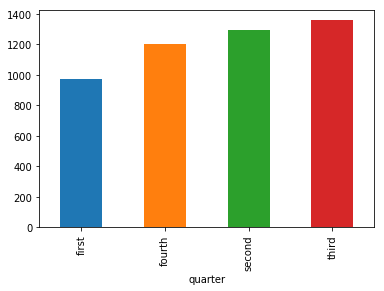

In [372]:
grouped_by_quarter.plot.bar(x = "quarter", y = "#total_items")

 As we see, we made a sum of each quarter items for every year, and we can notice that the quarter with more activity from 2015 till 2017 was the third quarter